<a href="https://colab.research.google.com/github/tom2rd/Googlecolabutils/blob/master/Electromagnetics/SimPEG_plot_inversion_linear_irls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install SimPEG

     |████████████████████████████████| 256kB 2.9MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 593kB 43.0MB/s 
  Created wheel for SimPEG: filename=SimPEG-0.12.0-cp36-none-any.whl size=298568 sha256=bce2b8031cbac9809f974355e79a7f7037967da052a4935e6ad42492694ff153
  Stored in directory: /root/.cache/pip/wheels/2e/5a/e9/91fe65f3693bf49496c16b290be247c1ce2a83cbc0ecd6de89
  Created wheel for pymatsolver: filename=pymatsolver-0.1.2-cp36-none-any.whl size=15910 sha256=376e8e3c4c55b8cdcafda4df6a46be1e5a74f9abf3f0d8a71cd11a0822aee2f2
  Stored in directory: /root/.cache/pip/wheels/09/66/a3/c540b8d29d1edab2bd4fabe368987aedc7fda18e742672be5b
  Created wheel for properties: filename=properties-0.6.1-cp36-none-any.whl size=58336 sha256=4729fb98996434914566feae76721540840efc17e097264ba6debfc846910bcb
  Stored in directory: /root/.cache/pip/wheels/9d/d9/66/f1f984e6dbe9ca4fb0c51617e526a73945f90936d4ae040fc2
  Created wheel for vectormath: filename=

In [0]:
%matplotlib inline


Inversion: Linear: IRLS
=======================

Here we go over the basics of creating a linear problem and inversion.


SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.15e+06  5.36e+05  1.36e-07  5.36e+05    2.00e+01      0              
   1  5.74e+05  1.82e+05  8.95e-02  2.33e+05    1.94e+01      0              
   2  2.87e+05  1.20e+05  1.67e-01  1.68e+05    1.92e+01      0   Skip BFGS  
   3  1.43e+05  7.27e+04  2.83e-01  1.13e+05    1.91e+01      0   Skip BFGS  
   4  7.17e+04  4.11e+04  4.38e-01  7.24e+04    1.89e+01      0   Skip BFGS  
   5  3.59e+04  2.16e

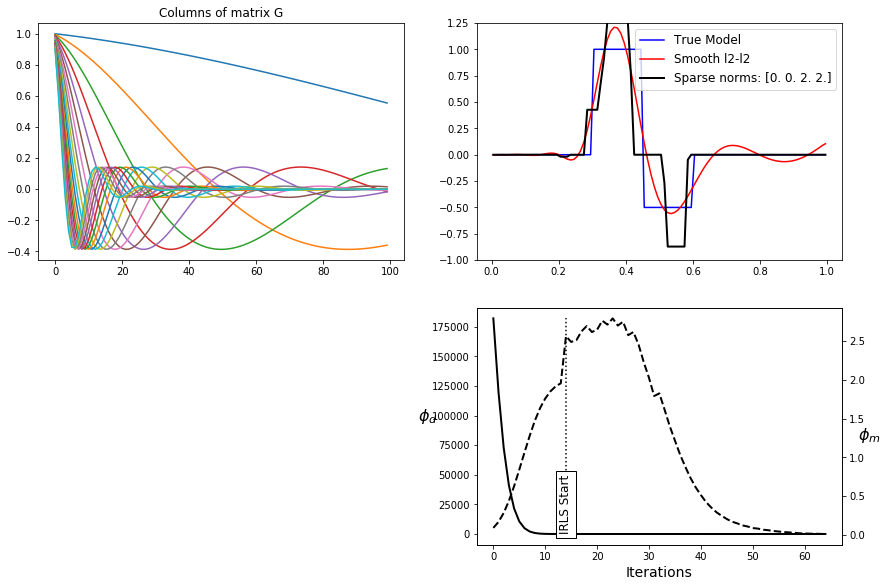

In [3]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from SimPEG import Mesh
from SimPEG import Problem
from SimPEG import Survey
from SimPEG import DataMisfit
from SimPEG import Directives
from SimPEG import Optimization
from SimPEG import Regularization
from SimPEG import InvProblem
from SimPEG import Inversion
from SimPEG import Maps


def run(N=100, plotIt=True):

    np.random.seed(1)

    std_noise = 1e-2

    mesh = Mesh.TensorMesh([N])

    m0 = np.ones(mesh.nC) * 1e-4
    mref = np.zeros(mesh.nC)

    nk = 20
    jk = np.linspace(1., 60., nk)
    p = -0.25
    q = 0.25

    def g(k):
        return (
            np.exp(p*jk[k]*mesh.vectorCCx) *
            np.cos(np.pi*q*jk[k]*mesh.vectorCCx)
        )

    G = np.empty((nk, mesh.nC))

    for i in range(nk):
        G[i, :] = g(i)

    mtrue = np.zeros(mesh.nC)
    mtrue[mesh.vectorCCx > 0.3] = 1.
    mtrue[mesh.vectorCCx > 0.45] = -0.5
    mtrue[mesh.vectorCCx > 0.6] = 0

    prob = Problem.LinearProblem(mesh, G=G)
    survey = Survey.LinearSurvey()
    survey.pair(prob)
    survey.dobs = prob.fields(mtrue) + std_noise * np.random.randn(nk)

    wd = np.ones(nk) * std_noise

    # Distance weighting
    wr = np.sum(prob.getJ(m0)**2., axis=0)**0.5
    wr = wr/np.max(wr)

    dmis = DataMisfit.l2_DataMisfit(survey)
    dmis.W = 1./wd

    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)

    # Creat reduced identity map
    idenMap = Maps.IdentityMap(nP=mesh.nC)

    reg = Regularization.Sparse(mesh, mapping=idenMap)
    reg.mref = mref
    reg.cell_weights = wr
    reg.norms = np.c_[0., 0., 2., 2.]
    reg.mref = np.zeros(mesh.nC)

    opt = Optimization.ProjectedGNCG(
        maxIter=100, lower=-2., upper=2.,
        maxIterLS=20, maxIterCG=10, tolCG=1e-3
    )
    invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
    update_Jacobi = Directives.UpdatePreconditioner()

    # Set the IRLS directive, penalize the lowest 25 percentile of model values
    # Start with an l2-l2, then switch to lp-norms

    IRLS = Directives.Update_IRLS(
        maxIRLSiter=40, minGNiter=1, f_min_change=1e-4)
    saveDict = Directives.SaveOutputEveryIteration(save_txt=False)
    inv = Inversion.BaseInversion(
        invProb,
        directiveList=[IRLS, betaest, update_Jacobi, saveDict]
    )

    # Run inversion
    mrec = inv.run(m0)

    print("Final misfit:" + str(invProb.dmisfit(mrec)))

    if plotIt:
        fig, axes = plt.subplots(2, 2, figsize=(12*1.2, 8*1.2))
        for i in range(prob.G.shape[0]):
            axes[0, 0].plot(prob.G[i, :])
        axes[0, 0].set_title('Columns of matrix G')

        axes[0, 1].plot(mesh.vectorCCx, mtrue, 'b-')
        axes[0, 1].plot(mesh.vectorCCx, invProb.l2model, 'r-')
        # axes[0, 1].legend(('True Model', 'Recovered Model'))
        axes[0, 1].set_ylim(-1.0, 1.25)

        axes[0, 1].plot(mesh.vectorCCx, mrec, 'k-', lw=2)
        axes[0, 1].legend(
            (
                'True Model',
                'Smooth l2-l2',
                'Sparse norms: {0}'.format(*reg.norms)
            ),
            fontsize=12
        )

        axes[1, 1].plot(saveDict.phi_d, 'k', lw=2)

        twin = axes[1, 1].twinx()
        twin.plot(saveDict.phi_m, 'k--', lw=2)
        axes[1, 1].plot(
            np.r_[IRLS.iterStart, IRLS.iterStart],
            np.r_[0, np.max(saveDict.phi_d)], 'k:'
        )
        axes[1, 1].text(
            IRLS.iterStart, 0.,
            'IRLS Start', va='bottom', ha='center',
            rotation='vertical', size=12,
            bbox={'facecolor': 'white'}
        )

        axes[1, 1].set_ylabel('$\phi_d$', size=16, rotation=0)
        axes[1, 1].set_xlabel('Iterations', size=14)
        axes[1, 0].axis('off')
        twin.set_ylabel('$\phi_m$', size=16, rotation=0)

    return prob, survey, mesh, mrec


if __name__ == '__main__':
    run()
    plt.show()